<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter05/age_gender_torch_snippets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ссылка на colab:

https://colab.research.google.com/drive/1xUIAVLrWFcL9Hwtwq4c5Bayf79FhRr0X

In [ ]:
%%capture
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)
!pip install torch_snippets
from torch_snippets import *

In [ ]:
%%capture
!pip install -U imgaug

In [ ]:
import imgaug



---



### Загрузим датасет

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kostyasereginmailru","key":"ad05ad97cdde449caa2e57874c5b2819"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 75 Aug 30 15:47 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

 99% 1.07G/1.08G [00:13<00:00, 111MB/s]
100% 1.08G/1.08G [00:13<00:00, 83.9MB/s]


In [ ]:
!unzip -qq /content/the-simpsons-characters-dataset.zip

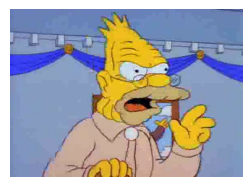

In [ ]:
show('/content/simpsons_dataset/abraham_grampa_simpson/pic_0005.jpg', sz=3)

In [ ]:
read('/content/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg')

array([[142, 142, 142, ..., 127, 127, 127],
       [142, 142, 142, ..., 127, 127, 127],
       [142, 142, 142, ..., 127, 127, 127],
       ...,
       [ 39,  39,  39, ...,  99,  99,  99],
       [ 39,  39,  39, ...,  99,  99,  99],
       [ 39,  39,  39, ...,  99,  99,  99]], dtype=uint8)

In [ ]:
def to_DataFrame(way):
  data_image_paths = [str(i) for i in Glob(f'{way}/*/*.jpg')]
  data_image_labels = [str(path).split('/')[-2] for path in Glob(f'{way}/*/*.jpg')]
  simps_train, simps_test = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
    )
#  trn_files, test_files = train_test_split(way_to_picture, test_size=0.1, random_state=1)
#  simps_train = [i.split('/')[-2] for i in trn_files]
#  simps_test = [i.split('/')[-2] for i in test_files]

  dct_codes = {l:t for t,l in enumerate(set([i.split('/')[-2] for i in simps_train]))}
  target_tr = []
  target_test = []

  codes_tr = []
  for i in simps_train:
   target_tr.append(i.split('/')[-2])
   for j in dct_codes:
     if j == i.split('/')[-2]:
        codes_tr.append(dct_codes[j])

  codes_test = []
  for i in simps_test:
    target_test.append(i.split('/')[-2])
    for j in dct_codes:
      if i.split('/')[-2] == j:
        codes_test.append(dct_codes[j])

  data_tr ={'way': simps_train,
            'persons': target_tr,
            'codes': codes_tr}
  data_test ={'way': simps_test,
              'persons': target_test,
              'codes': codes_test}
  df_tr = pd.DataFrame(data_tr)
  df_test = pd.DataFrame(data_test)

  return df_tr, df_test, dct_codes
#  return len(simps_train), len(target_tr), len(codes_tr)

In [ ]:
df_tr, df_test, dct_codes = to_DataFrame('/content/simpsons_dataset')

In [ ]:
df_tr.head(4)

,way,persons,codes
0,/content/simpsons_dataset/patty_bouvier/pic_00...,patty_bouvier,23
1,/content/simpsons_dataset/krusty_the_clown/pic...,krusty_the_clown,1
2,/content/simpsons_dataset/snake_jailbird/pic_0...,snake_jailbird,29
3,/content/simpsons_dataset/chief_wiggum/pic_013...,chief_wiggum,2


In [ ]:
df_test.head(4)

,way,persons,codes
0,/content/simpsons_dataset/charles_montgomery_b...,charles_montgomery_burns,2
1,/content/simpsons_dataset/moe_szyslak/pic_0698...,moe_szyslak,15
2,/content/simpsons_dataset/marge_simpson/pic_09...,marge_simpson,24
3,/content/simpsons_dataset/charles_montgomery_b...,charles_montgomery_burns,2


In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

In [ ]:
data_dir = '/content/simpsons_dataset'

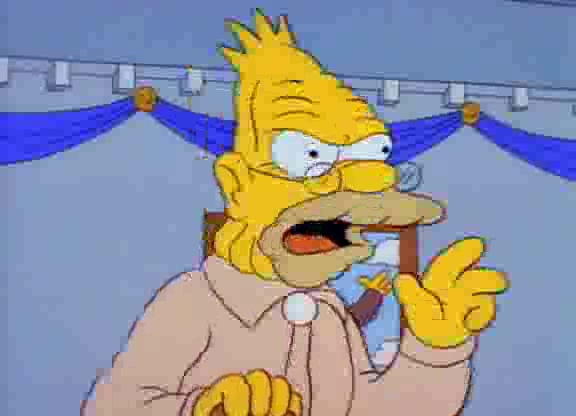

In [ ]:
Image.open('/content/simpsons_dataset/abraham_grampa_simpson/pic_0005.jpg')

In [ ]:
class f_t(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.way
        codes = f.codes
        im = train_transform(Image.open(file))
        return im, int(codes)

In [ ]:
class f_v(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.way
        codes = f.codes
        im = val_transform(Image.open(file))
        return im, int(codes)

In [ ]:
trn = f_t(df_tr)
val = f_v(df_test)

In [ ]:
train_loader = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(val, batch_size=32)



---



**Проверяем применяются ли фильтры**

Тренировочная

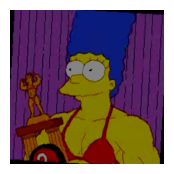

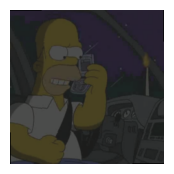

In [ ]:
for i,j in enumerate(trn):
  if i < 2:
    show(j[0],sz=2)
  else:   break

Тестовая

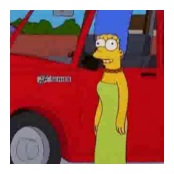

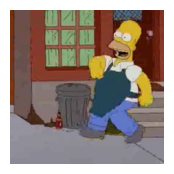

In [ ]:
for i,j in enumerate(val):
  if i < 2:
    show(j[0],sz=2)
  else:   break

Вывод: явно видно искажение train и что test близка к оригиналу



---



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history



---



# **Задание 1: меняем шаг обучения**

**1.1 Сеть обученная без изменения шага (веса используем обученные)**

In [ ]:
from torchvision.models import resnet18

Epoch 10 of 10 took 142.299s

training loss (in-iteration):         1.430167

validation loss (in-iteration):       1.201181

training accuracy:                    61.97 %

validation accuracy:                  69.42 %

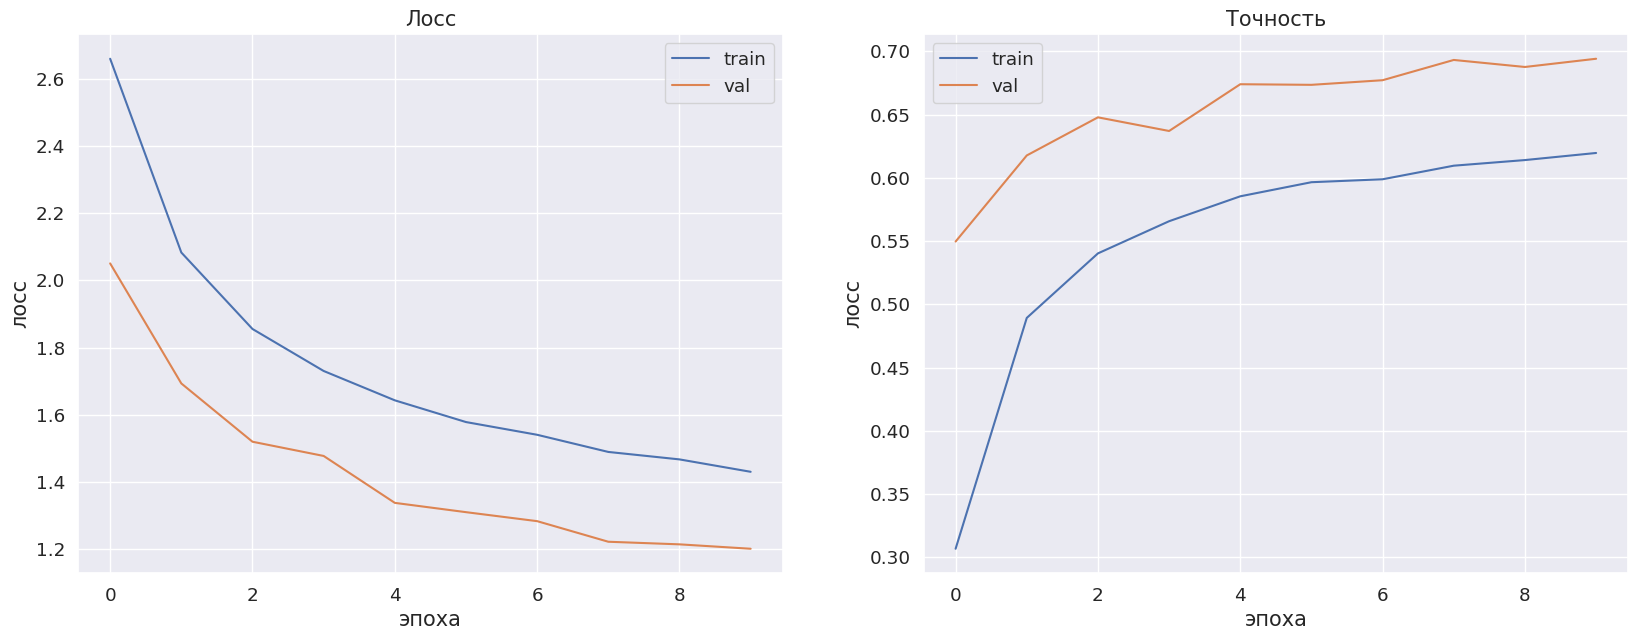

In [ ]:
# возьмём предобученную сеть
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=10
)

**1.2 Используем 1 вариант изменения шага**

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    ):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        scheduler.step()

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
from torch.optim.lr_scheduler import StepLR

Epoch 10 of 10 took 136.026s

training loss (in-iteration):         1.195407

validation loss (in-iteration):       1.010250

training accuracy:                    66.34 %

validation accuracy:                  72.73 %

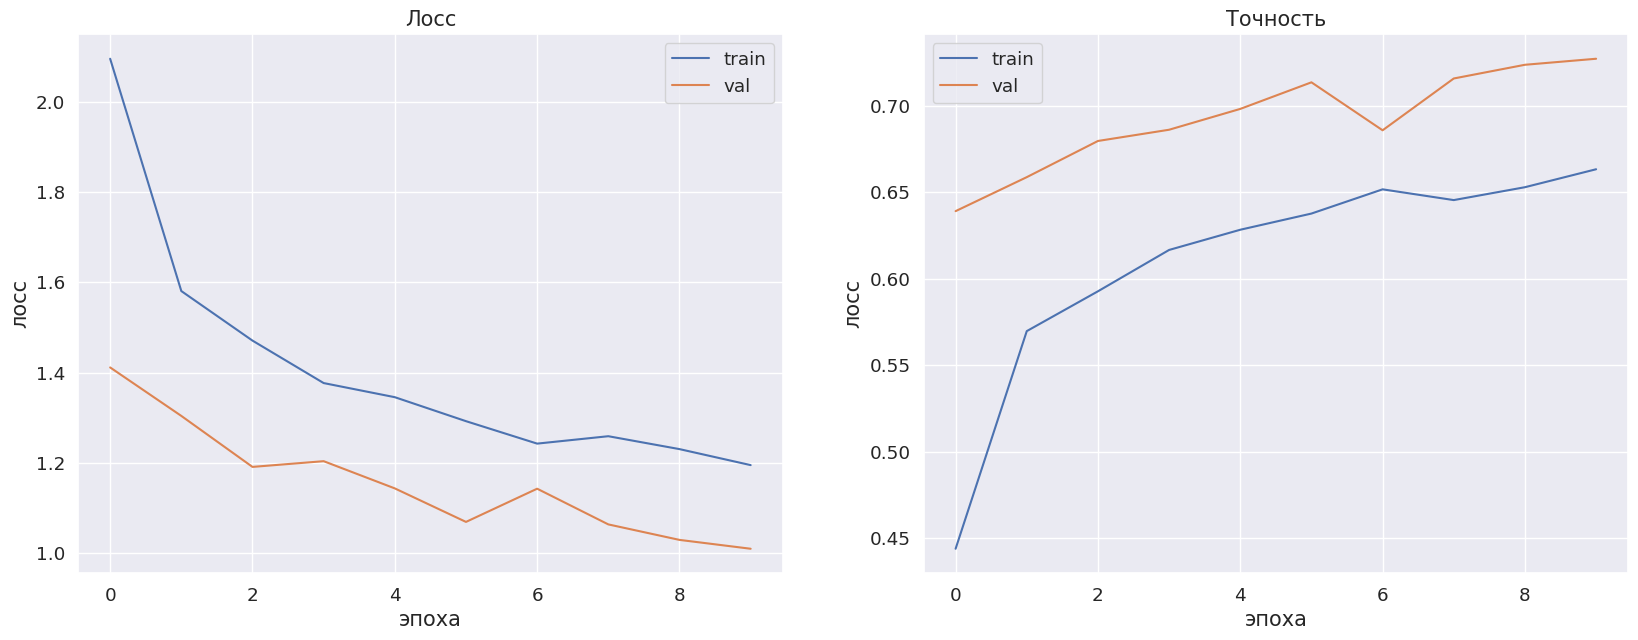

In [ ]:
# возьмём предобученную сеть
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    fe_model, criterion, optimizer, scheduler,
    train_loader, test_loader,
    num_epochs=10
)

**1.2 Используем 2 вариант изменения шага**

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    scheduler_1,
    scheduler_2,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    ):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)
        scheduler_1.step()
        scheduler_2.step()

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
from torch.optim.lr_scheduler import StepLR

Epoch 10 of 10 took 147.755s

training loss (in-iteration):         1.206132

validation loss (in-iteration):       1.026267

training accuracy:                    66.25 %

validation accuracy:                  72.49 %

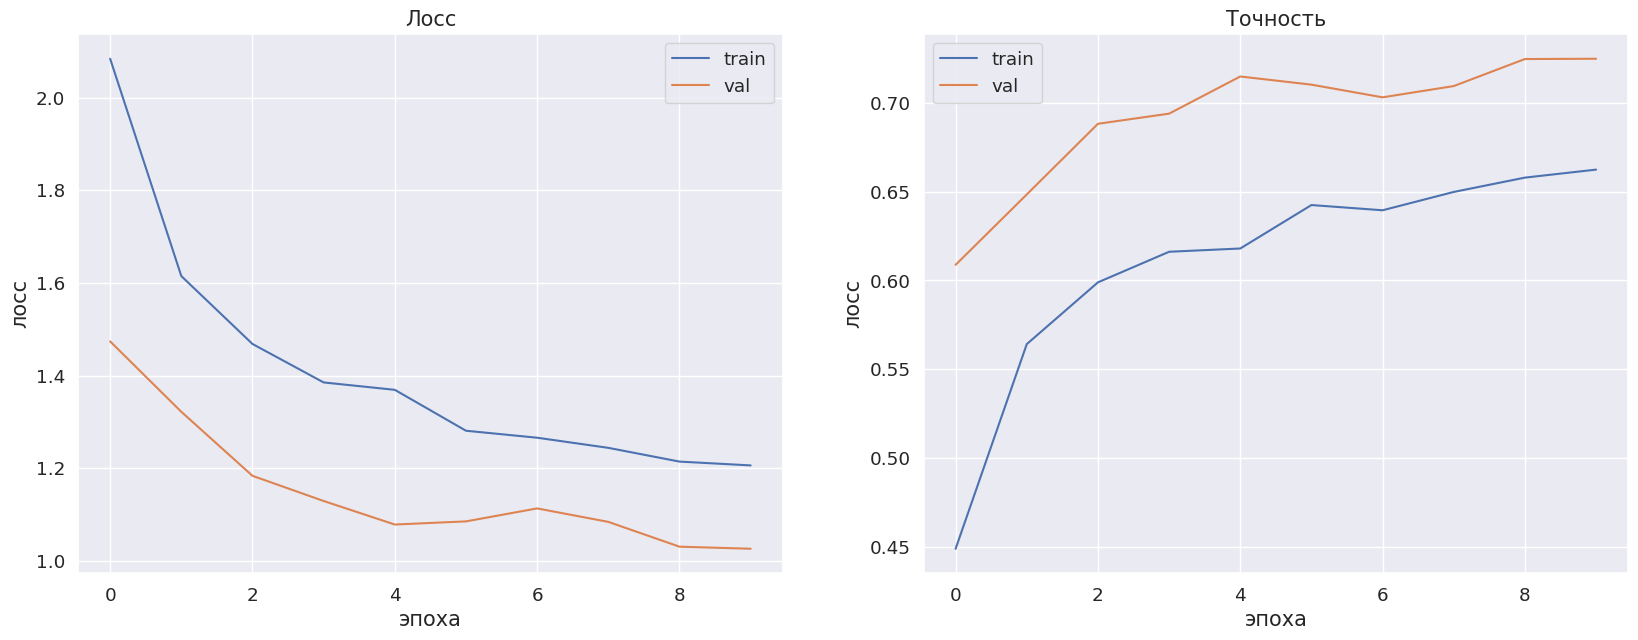

In [ ]:
# возьмём предобученную сеть
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01, momentum=0.9)
scheduler_1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler_2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

clf_model, history = train(
    fe_model, criterion, optimizer,
    scheduler_1, scheduler_2,
    train_loader, test_loader,
    num_epochs=10
)

# **Задание 2: меняем аугментацию, чтобы качество валидации сильно ухудшилось**

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(100),
    T.RandomResizedCrop(size=(32, 32)),
#    transforms.AugMix(10),
#    transforms.ElasticTransform(alpha=150.0),
    transforms.RandomInvert(4),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

In [ ]:
class f_t(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.way
        codes = f.codes
        im = train_transform(Image.open(file))
        return im, int(codes)

In [ ]:
trn = f_t(df_tr)
val = f_v(df_test)

In [ ]:
train_loader = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(val, batch_size=32)

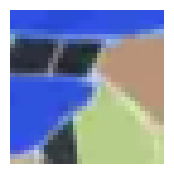

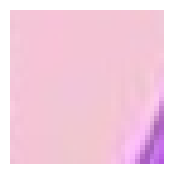

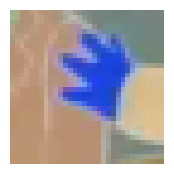

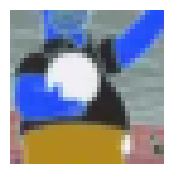

In [ ]:
for i,j in enumerate(trn):
  if i < 4:
    show(j[0],sz=2)
  else:   break

Epoch 10 of 10 took 86.848s

training loss (in-iteration):         2.712624

validation loss (in-iteration):       4.194599

training accuracy:                    23.52 %

validation accuracy:                  5.47 %

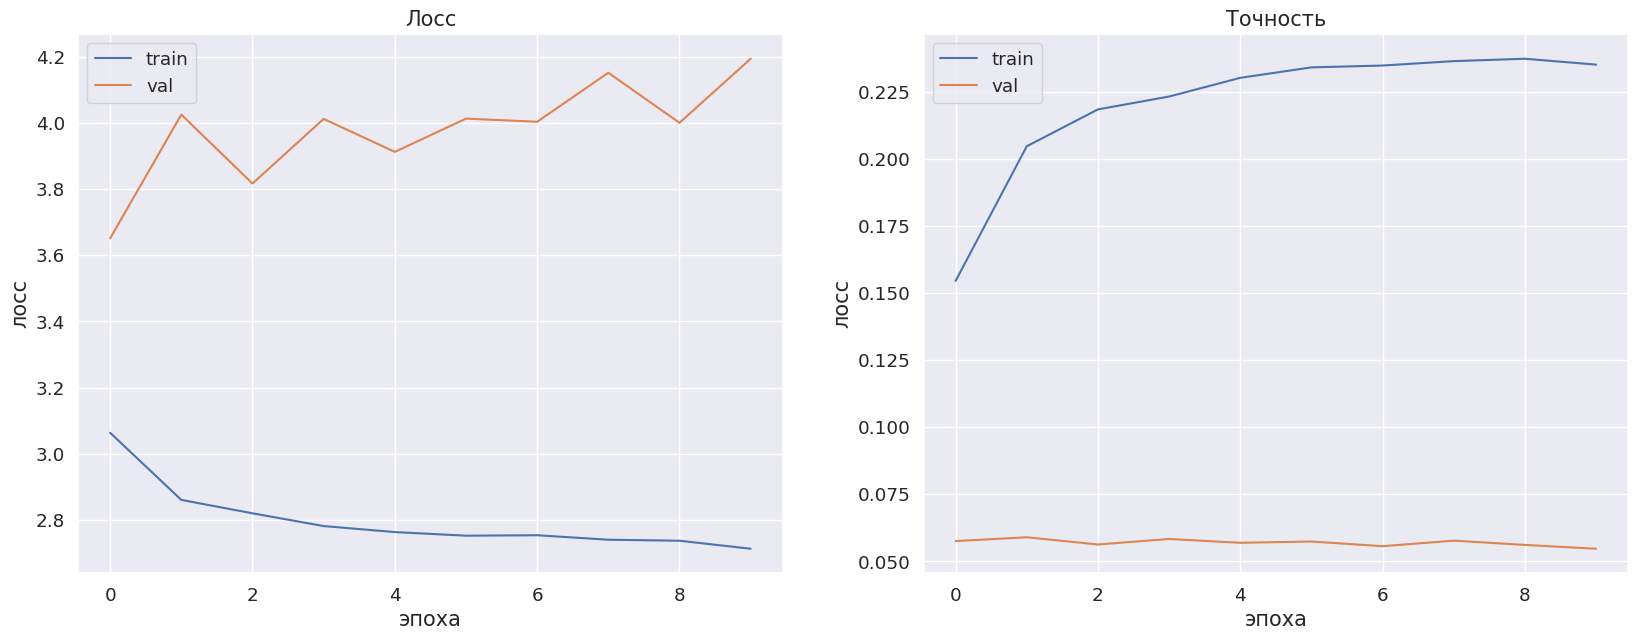

In [ ]:
# возьмём предобученную сеть
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=10
)

# **Задание 3: обучаем VGG16 по аналогии с уроком.**

**3.1 pretrained=False**

In [ ]:
from torchvision.models import vgg16

In [ ]:
model = vgg16(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model

In [ ]:
for name, param in model.named_parameters():
  param.requires_grad = False

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=42)

In [ ]:
model.classifier[6]

Linear(in_features=4096, out_features=42, bias=True)

In [ ]:
unfreeze_layers = [model.classifier[6]]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

Epoch 10 of 10 took 209.322s

training loss (in-iteration):         3.160542

validation loss (in-iteration):       3.110235

training accuracy:                    10.72 %

validation accuracy:                  10.69 %

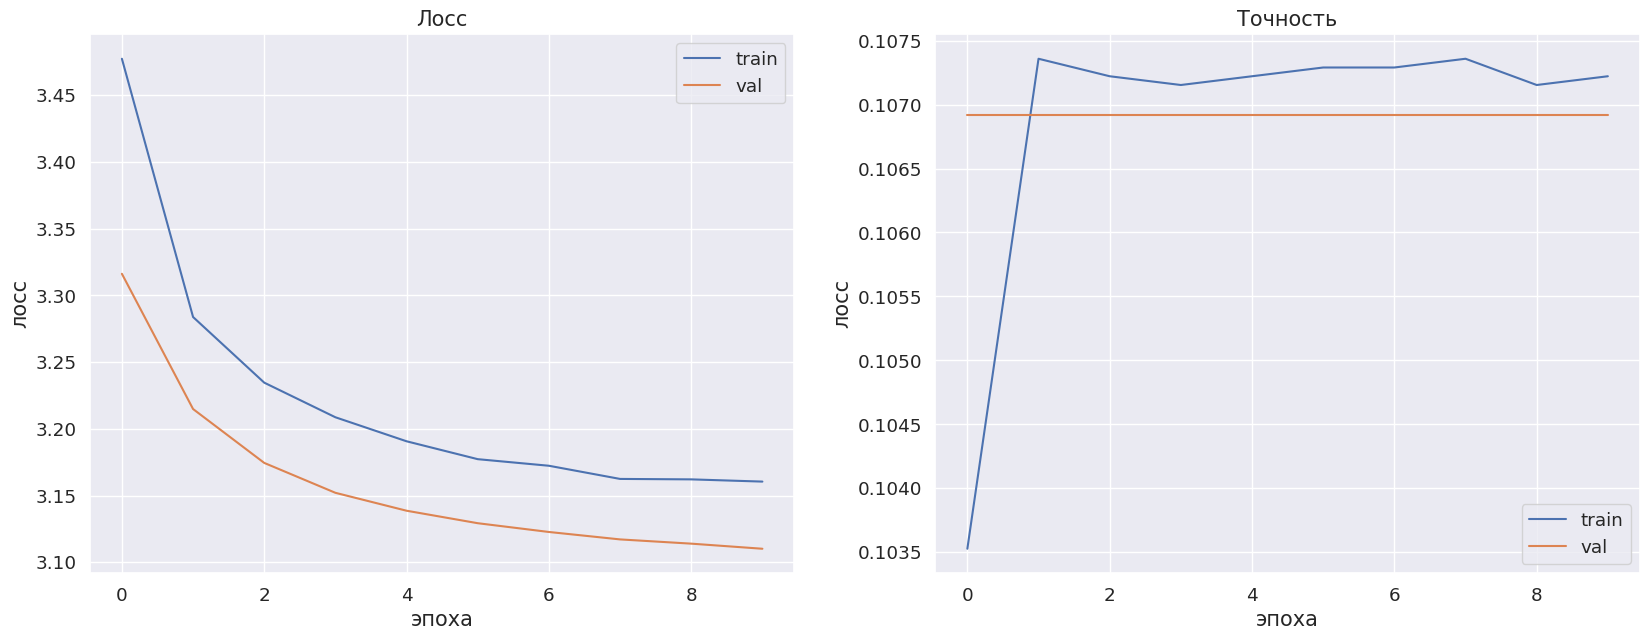

In [ ]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=10
)

**3.2 pretrained=True**

In [ ]:
from torchvision.models import vgg16

In [ ]:
model = vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

In [ ]:
for name, param in model.named_parameters():
  param.requires_grad = False

In [ ]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=42)

In [ ]:
model.classifier[6]

Linear(in_features=4096, out_features=42, bias=True)

In [ ]:
unfreeze_layers = [model.classifier[6]]
for layer in unfreeze_layers:
 for param in layer.parameters():
  param.requires_grad = True

Epoch 10 of 10 took 210.360s

training loss (in-iteration):         2.200352

validation loss (in-iteration):       1.675405

training accuracy:                    38.40 %

validation accuracy:                  56.04 %

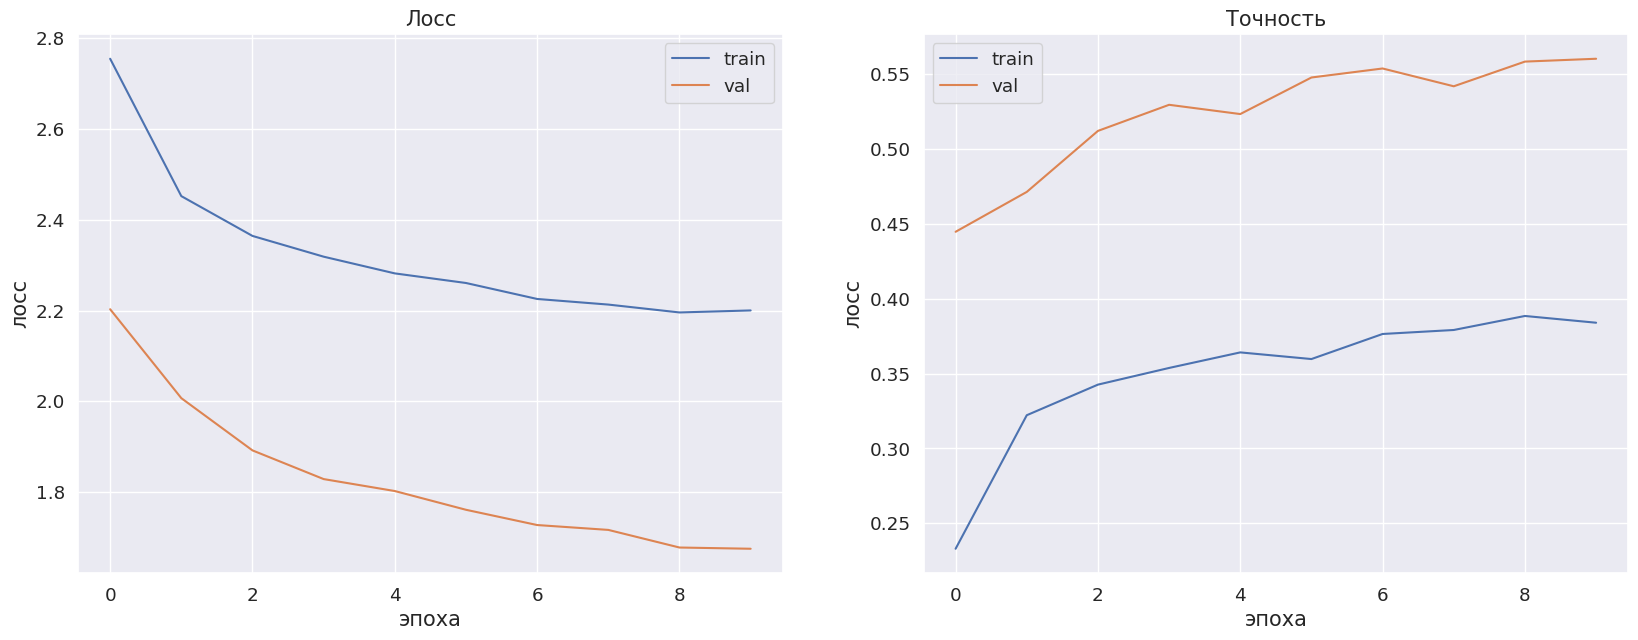

In [ ]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=10
)

**3.1 pretrained=True + добавление новых слоев**

In [ ]:
from torchvision.models import vgg16

In [ ]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('vgg16', vgg16(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
fine_tuning_model

Sequential(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [ ]:
for i in fine_tuning_model.parameters():
  print(i)

Epoch 10 of 10 took 359.274s

training loss (in-iteration):         0.073876

validation loss (in-iteration):       0.266630

training accuracy:                    97.85 %

validation accuracy:                  95.19 %

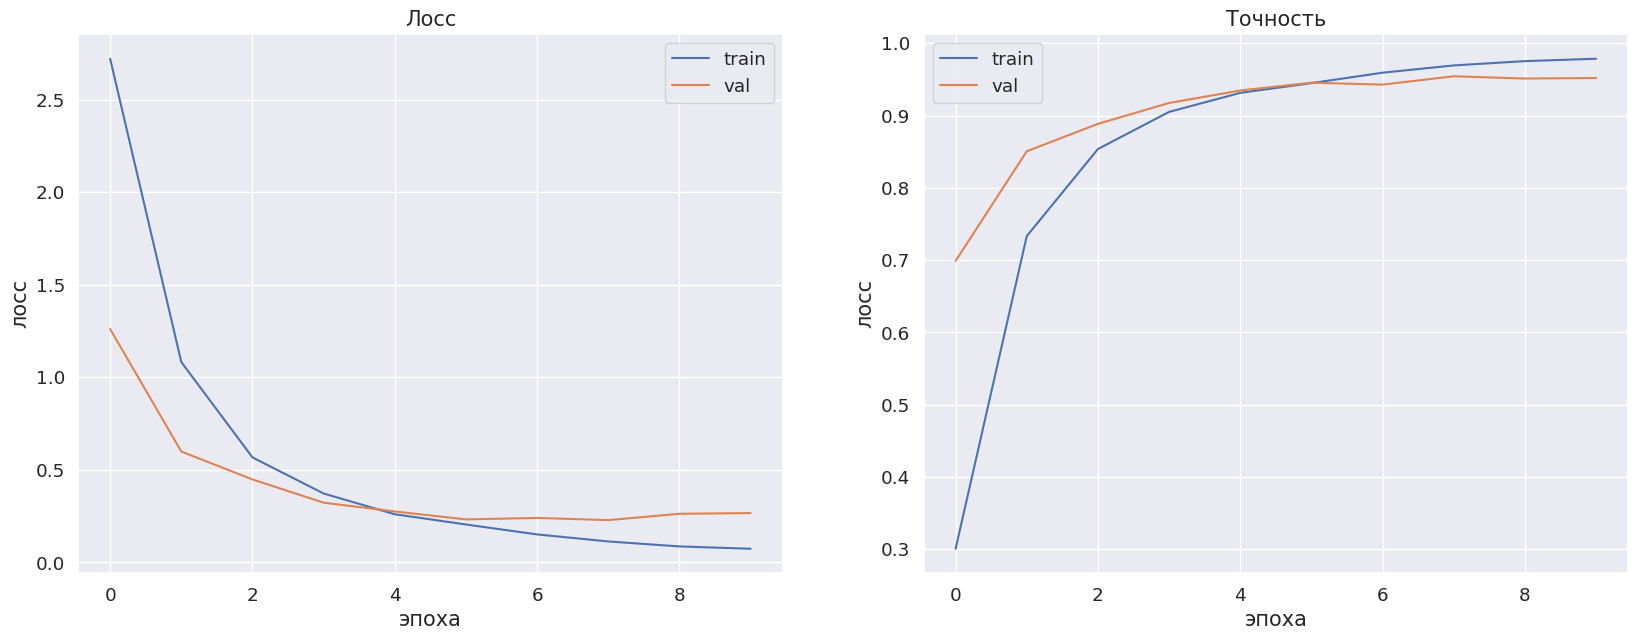

In [ ]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=10
)

# Вывод:
**Задание 1:** в обоих вариантах применения LR Schedulers качество модели растет примерно одинаково.

**Задание 2:** в качестве вывода можно сделать заключение о том, что аугментацию нужно применять осторожно, т.к. она может модель как улучнить, так и ухудшить.

**Задание 3:** Если модель использовать без обученных весов, то качество очень низкое, когда веса предварительно обучены, то качество возрастает, но незначительно (т.к. модель обучалась на фото, а здесь рисунки). В случае, когда добавлены дополнительные слои, то качество становится очень хорошим (возможно было достаточно разморозить все слои проследнего блока classifier), правда в конце модель начинает незначительно переобучаться, возмодно помогло бы введение слоев Dropout().




**